# Late Payments Model Improvements

This notebook is adapted from the code in `predict-late-payers-basic-model.py`.

The code here is admittedly messy, but a few markdown cells guide the reader into the different sections.


## Executive summary of impovements:

* A quick exploration of the features and labels was added.
* Accuracy was not a good metric.  This dataset has extreme class imbalance, and the predicted late-payer scores rarely rise above the default 50% threshold.  Even precision and recall won't tell much.  To better evaluate performance, we look at ROC-AUC; this can be interpreted as the probability that two randomly sampled predicted late-payer scores are ranked appropriately.
* Based on the metric above, the hyperparameters of the original random-forest model was optimized using a cross-validated grid search.  This improved ROC-AUC score on the test set, but the train and test set were still out of line, indicating poor generalization.
* A gradient-boosted classifier was trained with default parameters since these models generally work well out of the box.  The ROC-AUC on the test set slightly outperformed the optimized random-forest model, but was much closer to that of the train set, suggesting this model generalizes better.


In [1]:
# Import Libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
import seaborn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Preprocessing and Pipeline libraries
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import roc_curve
import pickle

In [2]:
print("\nLoading training data...")
# load training data
test_data = pd.read_csv("data/peerLoanTraining.csv", engine='python', header=0)

# Separate out X and y
X_train = test_data.loc[:, test_data.columns != 'is_late']
y_train = test_data['is_late']

# load test data
test_data = pd.read_csv("data/peerLoanTest.csv", engine='python', header=0)

# Separate out X and y
X_test = test_data.loc[:, test_data.columns != 'is_late']
y_test = test_data['is_late']

# Preprocessing Steps
numeric_features = ['loan_amnt', 
                    'int_rate', 'annual_inc', 'revol_util', 
                    'dti', 'delinq_2yrs'
                   ]


categorical_features = ['purpose','grade', 'emp_length', 'home_ownership']


Loading training data...


## Explore features

Histograms, descriptive stats, null counts

## loan_amnt

'Null counts: '

False    111068
Name: loan_amnt, dtype: int64

count    111068.000000
mean      15333.901304
std        9903.827140
min        1000.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
Name: loan_amnt, dtype: float64

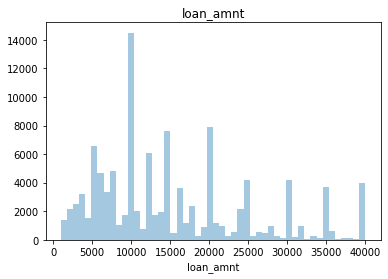

## int_rate

'Null counts: '

False    111068
Name: int_rate, dtype: int64

count    111068.000000
mean          0.123530
std           0.049712
min           0.053100
25%           0.080800
50%           0.119800
75%           0.150400
max           0.309900
Name: int_rate, dtype: float64

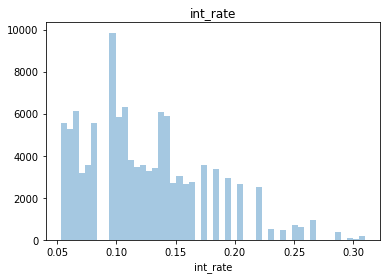

## annual_inc

'Null counts: '

False    111068
Name: annual_inc, dtype: int64

count    1.110680e+05
mean     8.152713e+04
std      8.914149e+04
min      2.300000e+03
25%      4.800000e+04
50%      6.800000e+04
75%      9.800000e+04
max      9.930475e+06
Name: annual_inc, dtype: float64

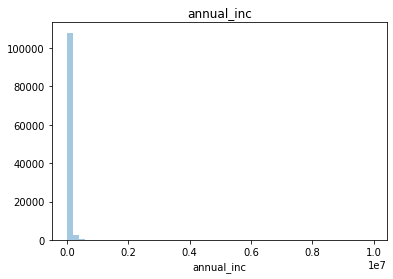

## revol_util

'Null counts: '

False    110951
True        117
Name: revol_util, dtype: int64

count    110951.000000
mean          0.432369
std           0.247957
min           0.000000
25%           0.236000
50%           0.413000
75%           0.616000
max           1.244000
Name: revol_util, dtype: float64

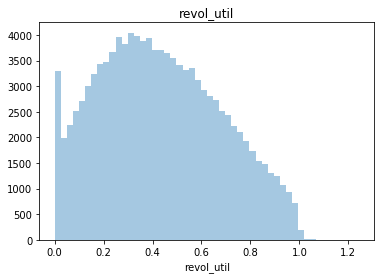

## dti

'Null counts: '

False    111068
Name: dti, dtype: int64

count    111068.000000
mean         17.334945
std           8.750318
min           0.000000
25%          10.750000
50%          16.700000
75%          23.410000
max          39.990000
Name: dti, dtype: float64

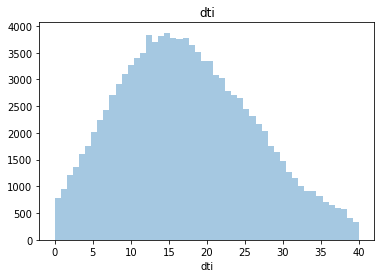

## delinq_2yrs

'Null counts: '

False    111068
Name: delinq_2yrs, dtype: int64

count    111068.000000
mean          0.236450
std           0.750367
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          23.000000
Name: delinq_2yrs, dtype: float64

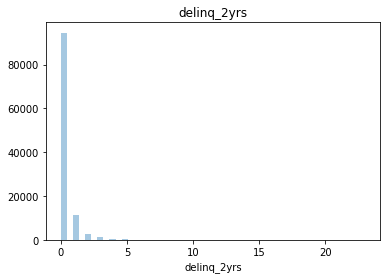

## purpose

'Null counts: '

False    111068
Name: purpose, dtype: int64

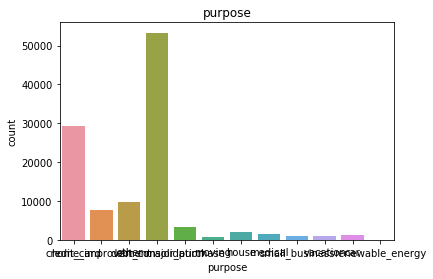

## grade

'Null counts: '

False    111068
Name: grade, dtype: int64

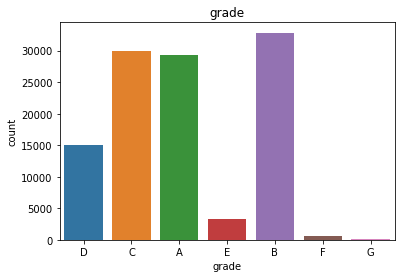

## emp_length

'Null counts: '

False    103321
True       7747
Name: emp_length, dtype: int64

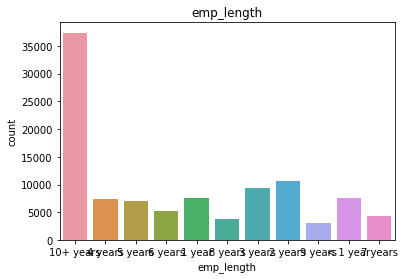

## home_ownership

'Null counts: '

False    111068
Name: home_ownership, dtype: int64

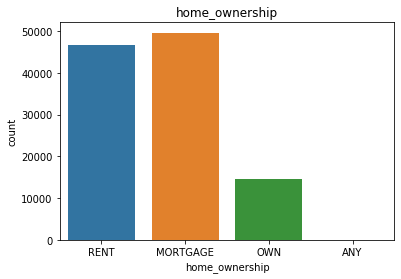

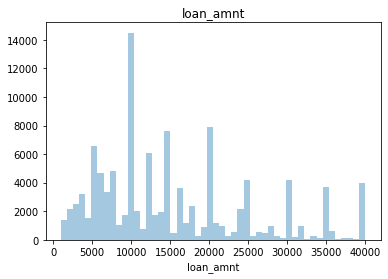

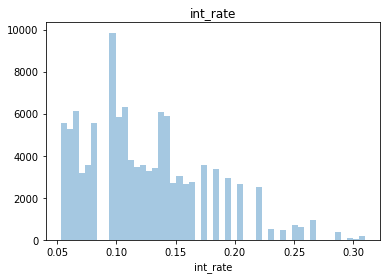

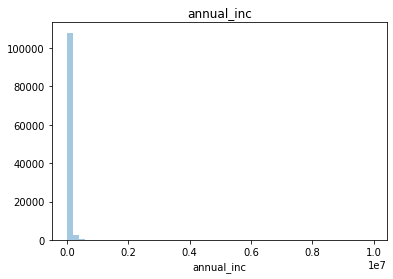

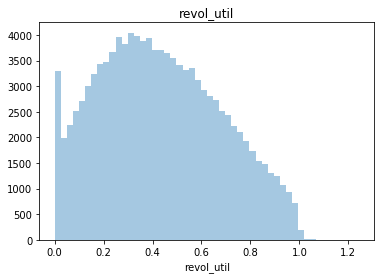

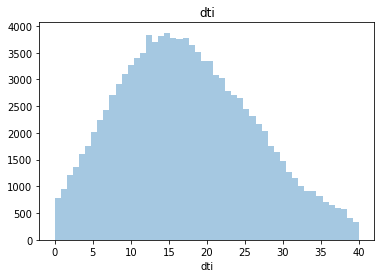

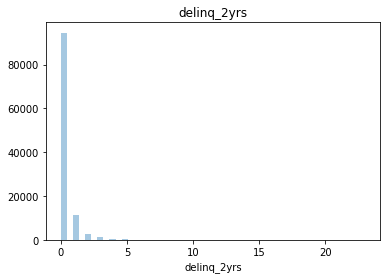

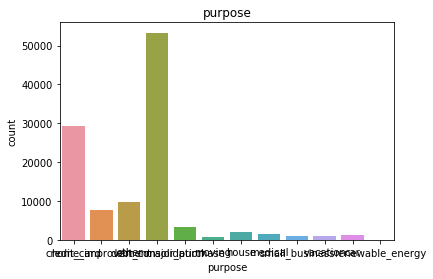

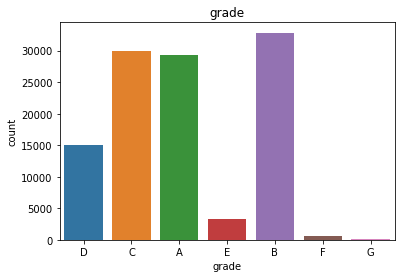

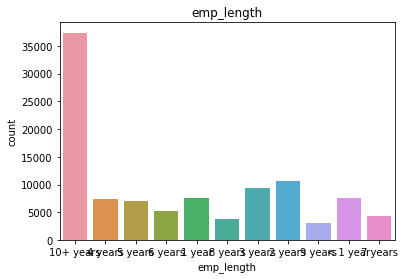

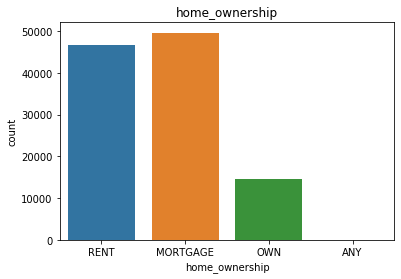

In [3]:
import seaborn
from IPython.core import display

for feature in numeric_features:
    
    display.display(display.Markdown(f"## {feature}"))
    display.display("Null counts: ")
    display.display(X_train[feature].isnull().value_counts())
    display.display(X_train[feature].describe())
    fig = pyplot.figure()
    seaborn.distplot(X_train[feature].dropna(), kde=False);
    pyplot.title(feature)
    display.display(fig)
    
for feature in categorical_features:
    display.display(display.Markdown(f"## {feature}"))
    display.display("Null counts: ")
    display.display(X_train[feature].isnull().value_counts())
    fig = pyplot.figure()
    seaborn.countplot(X_train[feature].dropna())
    pyplot.title(feature)
    display.display(fig)


## Class imbalance 

Take a look at the class label frequency, raw and normalized.

In [4]:
display.display(pd.DataFrame({"Raw Count - Train": y_train.value_counts(),
                              "Raw Count - Test": y_test.value_counts(),
                              "Normalized Count - Train": y_train.value_counts(normalize=True),
                              "Normalized Count - Test": y_test.value_counts(normalize=True),
                             }))


,Raw Count - Train,Raw Count - Test,Normalized Count - Train,Normalized Count - Test
0,108608,6748,0.977851,0.986117
1,2460,95,0.022149,0.013883


## Train/test/output procedure
Define this as a function so we can repeat for different models

There are some additional evaluation metrics added to the information printed to the screen

In [5]:
def fit_save_eval(model, name):
    print("\nTraining model ...")
    model.fit(X_train, y_train)

    # Save the trained model as a pickle file
    print("\nSaving model ...")
    model_output_path = f'models/{name}.pkl'
    file = open(model_output_path, 'wb')
    pickle.dump(model, file)
    file.close()

    # load the pickled model
    print("\nLoading saved model to make example predictions...")
    pickledModel = pickle.load(open(model_output_path, 'rb'))

    # Make a prediction for a likely on time payer
    payOnTimePrediction = {
        'loan_amnt': [100],
        'int_rate': [0.02039],
        'purpose': ['credit_card'],
        'grade': ['A'],
        'annual_inc': [80000.00],
        'revol_util': [0.05],
        'emp_length': ['10+ years'],
        'dti': [1.46],
        'delinq_2yrs': [0],
        'home_ownership': ['RENT']
        }
    payOnTimePredictionDf = pd.DataFrame.from_dict(payOnTimePrediction)

    print("\nPredicting class probabilities for likely on-time payer:")
    print(pickledModel.predict_proba(payOnTimePredictionDf))

    # Prediction for a likely late payer
    payLatePrediction = {
        'loan_amnt': [10000],
        'int_rate': [0.6],
        'purpose': ['credit_card'],
        'grade': ['D'],
        'annual_inc': [20000.00],
        'revol_util': [0.85],
        'emp_length': ['1 year'],
        'dti': [42.00],
        'delinq_2yrs': [4],
        'home_ownership': ['RENT']
        }
    payLatePredictionDf = pd.DataFrame.from_dict(payLatePrediction)

    print("\nPredicting class probabilities for a likely late payer:")
    print(pickledModel.predict_proba(payLatePredictionDf))

    # Predict class probabilities for a set of records using the test set
    print("\nPredicting class probabilities for the test data set:")
    print(pickledModel.predict_proba(X_test))

    from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
    print("Accuracy:\n%s" % accuracy_score(y_test, pickledModel.predict(X_test)))
    print("Classification Report: \n%s" %
          classification_report(y_test, pickledModel.predict(X_test)))
    print("AUC: \n%s" %
          roc_auc_score(y_test, pickledModel.predict_proba(X_test)[:, 1]))
    print("Train Accuracy:\n%s" % accuracy_score(y_train, pickledModel.predict(X_train)))
    print("Train Classification Report: \n%s" %
          classification_report(y_train, pickledModel.predict(X_train)))
    print("Train AUC: \n%s" %
          roc_auc_score(y_train, pickledModel.predict_proba(X_train)[:, 1]))


## Train original model

Train the same random-forest model pipeline that was used in `predict-late-payers-basic-model.py`.

In [6]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', None)
    ])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
        ]
    )

# Combine preprocessing with classifier
latePaymentsModel = Pipeline(
    steps=[("preprocess", preprocess),
           ("classifier", RandomForestClassifier(random_state=42))])

fit_save_eval(latePaymentsModel, "latePaymentsModelOriginal")



Training model ...


/anaconda3/envs/loanModel/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Saving model ...

Loading saved model to make example predictions...

Predicting class probabilities for likely on-time payer:
[[1. 0.]]

Predicting class probabilities for a likely late payer:
[[0.7 0.3]]

Predicting class probabilities for the test data set:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
Accuracy:
0.9861172000584539
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6748
           1       0.00      0.00      0.00        95

   micro avg       0.99      0.99      0.99      6843
   macro avg       0.49      0.50      0.50      6843
weighted avg       0.97      0.99      0.98      6843

AUC: 
0.6196307677908464


/anaconda3/envs/loanModel/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train Accuracy:
0.9945528865199698
Train Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    108608
           1       1.00      0.75      0.86      2460

   micro avg       0.99      0.99      0.99    111068
   macro avg       1.00      0.88      0.93    111068
weighted avg       0.99      0.99      0.99    111068

Train AUC: 
0.999951187548208


## Optimize original model

Use a cross-validated grid search to optimize the original model over a reasonable set of parameters.

In [7]:
param_grid = {"classifier__n_estimators": [10, 20, 30],
              "classifier__max_depth": [3, 10, 20],
              "classifier__class_weight": ["balanced", None],
              "preprocess__num__scaler": [RobustScaler(), None]
              }
latePaymentsModelGrid = GridSearchCV(latePaymentsModel,
                                 param_grid=param_grid,
                                 scoring='roc_auc',
                                 cv=5,
                                 n_jobs=-1)

fit_save_eval(latePaymentsModelGrid, "latePaymentsModelGrid")

print(latePaymentsModelGrid.best_params_)


Training model ...

Saving model ...

Loading saved model to make example predictions...

Predicting class probabilities for likely on-time payer:
[[0.99615619 0.00384381]]

Predicting class probabilities for a likely late payer:
[[0.8617744 0.1382256]]

Predicting class probabilities for the test data set:
[[0.97755935 0.02244065]
 [0.99561834 0.00438166]
 [0.99302074 0.00697926]
 ...
 [0.9716677  0.0283323 ]
 [0.98443126 0.01556874]
 [0.96516159 0.03483841]]
Accuracy:
0.9861172000584539
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6748
           1       0.00      0.00      0.00        95

   micro avg       0.99      0.99      0.99      6843
   macro avg       0.49      0.50      0.50      6843
weighted avg       0.97      0.99      0.98      6843



/anaconda3/envs/loanModel/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


AUC: 
0.7358952360153495
Train Accuracy:
0.9778514063456621


/anaconda3/envs/loanModel/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    108608
           1       0.00      0.00      0.00      2460

   micro avg       0.98      0.98      0.98    111068
   macro avg       0.49      0.50      0.49    111068
weighted avg       0.96      0.98      0.97    111068

Train AUC: 
0.8520278754413575
{'classifier__class_weight': None, 'classifier__max_depth': 10, 'classifier__n_estimators': 30, 'preprocess__num__scaler': None}


## Train a gradient-boosted model

Try a gradient boosted model, because they generally work well out of the box.

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

latePaymentsModelGradient = Pipeline(
    steps=[("preprocess", preprocess),
           ("classifier", GradientBoostingClassifier(random_state=42))])

fit_save_eval(latePaymentsModelGradient, "latePaymentsModelGradient")


Training model ...

Saving model ...

Loading saved model to make example predictions...

Predicting class probabilities for likely on-time payer:
[[0.99666011 0.00333989]]

Predicting class probabilities for a likely late payer:
[[0.9219016 0.0780984]]

Predicting class probabilities for the test data set:
[[0.97564545 0.02435455]
 [0.99474814 0.00525186]
 [0.99062148 0.00937852]
 ...
 [0.96656566 0.03343434]
 [0.9843289  0.0156711 ]
 [0.96114738 0.03885262]]
Accuracy:
0.9861172000584539
Classification Report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      6748
           1       0.00      0.00      0.00        95

   micro avg       0.99      0.99      0.99      6843
   macro avg       0.49      0.50      0.50      6843
weighted avg       0.97      0.99      0.98      6843

AUC: 
0.7452664337191527


/anaconda3/envs/loanModel/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train Accuracy:
0.9779594482659272
Train Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    108608
           1       1.00      0.00      0.01      2460

   micro avg       0.98      0.98      0.98    111068
   macro avg       0.99      0.50      0.50    111068
weighted avg       0.98      0.98      0.97    111068

Train AUC: 
0.7548989563720769


## Plot ROC curves for models trained


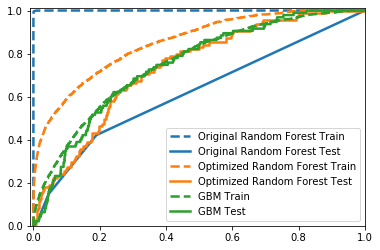

In [9]:
def plot_roc(model, color, name):
    tpr_train, fpr_train, _ = roc_curve(y_train, model.predict_proba(X_train)[:, 1])
    tpr_test, fpr_test, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    
    pyplot.plot(tpr_train,
                fpr_train,
                f'--',
                color=color,
                label=f'{name} Train',
                linewidth=2.5)
    pyplot.plot(tpr_test,
                fpr_test,
                f'-',
                color=color,
                label=f'{name} Test',
                linewidth=2.5)
    pyplot.legend()
    pyplot.xlim(-0.01, 1)
    pyplot.ylim(0, 1.01)

pal = seaborn.palettes.get_color_cycle()
plot_roc(latePaymentsModel, pal[0], 'Original Random Forest')
plot_roc(latePaymentsModelGrid, pal[1], 'Optimized Random Forest')
plot_roc(latePaymentsModelGradient, pal[2], 'GBM')
